<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Installs" data-toc-modified-id="Installs-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Installs</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Const" data-toc-modified-id="Const-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Const</a></span></li><li><span><a href="#Func" data-toc-modified-id="Func-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Func</a></span></li><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Data Load</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#BERT-на-GPU" data-toc-modified-id="BERT-на-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BERT на GPU</a></span><ul class="toc-item"><li><span><a href="#Загрузка-BERT-модели" data-toc-modified-id="Загрузка-BERT-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка BERT модели</a></span><ul class="toc-item"><li><span><a href="#Токенизация" data-toc-modified-id="Токенизация-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Токенизация</a></span></li></ul></li><li><span><a href="#Инициализация-эмбедингов" data-toc-modified-id="Инициализация-эмбедингов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Инициализация эмбедингов</a></span></li><li><span><a href="#Поправка-на-дисбаланс" data-toc-modified-id="Поправка-на-дисбаланс-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Поправка на дисбаланс</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Создание-класса-для-расчета-весов" data-toc-modified-id="Создание-класса-для-расчета-весов-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Создание класса для расчета весов</a></span></li><li><span><a href="#Поготовка-пайплайна" data-toc-modified-id="Поготовка-пайплайна-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Поготовка пайплайна</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин заказал разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 



### Installs

### Imports

In [53]:
import os
import math
import multiprocessing
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
import tensorflow as tf
from joblib import (
    Memory,
    dump,
    load
)

from torch.utils.data import(
    TensorDataset, 
    DataLoader
)

from torch.cuda.amp import (
    autocast, 
    GradScaler
)

from transformers import(
    AutoTokenizer,
    BertTokenizer,
    BertTokenizerFast,
    BertModel,
    TFBertModel,
    BertConfig
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import(
    train_test_split,
    RandomizedSearchCV
)

from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve, 
    auc
)
from tqdm import notebook

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier

### Const

In [2]:
model_name = "bert-base-uncased" 
model_path = 'C:\\Users\\NoName\\DS\\TEXTS\\models'
memory = Memory(location='./cache', verbose=0)
RANDOM_STATE = 42

# Если делать false то расчет эмбедингов увеличивается в 3 раза
os.environ["TOKENIZERS_PARALLELISM"] = "true"

### Warnings management

In [3]:
warnings.filterwarnings("ignore")
from transformers import logging
logging.set_verbosity_error()


### Func

In [4]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
def tokenize_and_prepare_gpu(data, model_name, device='cuda'):
    """
    Функция токенизации и подготовки данных с перемещением на GPU.    
    Args:
        data: DataFrame с текстом.
        device: Устройство ('cuda' для GPU, 'cpu' для CPU).
        model_name: Имя модели Bert, для инициализации AutoTokenizer. Стоит обратить внимание что Ддля моделей без учета регистра, 
                    таких как bert-base-uncased, AutoTokenizer автоматически преобразует текст в нижний регистр, 
                    как например сделал бы это BertTokenizer с параметром do_lower_case=True.
    Returns:
        Тензоры input_ids и attention_mask на указанном устройстве.
    """
    # Загрузка токенизатора. Файл словаря автоматически загружается и используется токенизатором.
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # padding- чтобы после токенизации длины исходных текстов в корпусе были одиннаковыми. 
    # add_special_tokens - добавим токен начала (101) и токен конца текста (102) к любому преобразуемому тексту
    # truncation=True - исключить токены, превышающие длинну max_length.
    encoded_data = tokenizer(
        list(data['text']),
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    # Оптимизируем процесс расчета эмбедингов, путем переноса тензоров с токенами на GPU
    input_ids = encoded_data['input_ids'].to(device)
    # Установим маску внимания чтобы модель, понимала что нули не несут значимой информации и такие токены можно отбросить. 
    # Это нужно для компоненты модели attention
    attention_mask = encoded_data['attention_mask'].to(device)
    
    return input_ids, attention_mask

def get_embeddings_gpu(input_ids, attention_mask, model, batch_size=32, device='cuda:0',cache_file='embeddings.joblib'):
    """
    Функция пакетной обработки данных для получения эмбеддингов из модели BERT 
    с использованием GPU и CUDA.

    Args:    
        input_ids: Тензор, содержащий идентификаторы токенов входного текста.
        attention_mask: Тензор, определяющий, какие токены следует учитывать (1) и какие игнорировать (0) во время вычислений.
        model: Модель BERT, уже загруженная и готовая к использованию.
        batch_size: Размер пакета данных, используемый для обработки.
        device: Устройство, на котором будут выполняться вычисления ('cuda:0' для GPU, 'cpu' для CPU).
    Returns:
        NumPy массив с эмбеддингами.
    """
    
    # Проверка кэша
    # 1. Получение пути к текущему файлу
    current_dir =  os.getcwd()
    
    # 2. Формирование пути к дирректории cached
    cache_dir = os.path.join(current_dir, 'cached')
    
    # 3. Создание дирректории cached, если ее не существует
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    # 4. Формирование полного пути к файлу кэша
    cache_file = os.path.join(cache_dir, cache_file)

    if os.path.exists(cache_file):
        print("Загружаем эмбеддинги из кэша...")
        return load(cache_file)
    
    # Перемещение модели на GPU
    model.to(device) 
    
    # Расчитаем количество итераций для tqdm
    total_batches = math.ceil(input_ids.shape[0] / batch_size)
    
    embeddings = []

    # Пакетная итерирация по входным данным
    for batch_input_ids, batch_attention_mask in notebook.tqdm(zip(torch.split(input_ids, batch_size), 
                                                                   torch.split(attention_mask, batch_size)
                                                                  ), total = total_batches
                                                              ):
        # Перемещение пакетов на GPU и обработка
        batch_input_ids = batch_input_ids.to(device, non_blocking=True)
        batch_attention_mask = batch_attention_mask.to(device, non_blocking=True)
        # отключаем отслеживание градиентов, что необходимо, так как мы не обучаем модель, а используем ее для инференса.
        
        with torch.no_grad():
            # передаем пакет данных в модель BERT и получает выходные данные.
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

            # Извлекает эмбеддинги для токена [CLS] из последнего скрытого слоя модели. 
            # Токен [CLS] используется для представления всего предложения.
            batch_embeddings = batch_outputs.last_hidden_state[:, 0, :]

            #Перемещаем полученные эмбеддинги на CPU и преобразуем их в NumPy массив
            embeddings.append(batch_embeddings.cpu().numpy())  # Перемещение на CPU для объединения

    # Объединяем все эмбеддинги из списка embeddings в один большой NumPy массив.
    features = np.concatenate(embeddings)

    # Вернем тензоры обратно на CPU
    input_ids = input_ids.cpu()
    attention_mask = attention_mask.cpu()

    # Сохранение эмбеддингов в кэш
    print("Сохраняем эмбеддинги в кэш...")
    dump(features, cache_file)

    
    return features    

def plot_roc_auc(y_true, y_pred_proba):
  """
  Отрисовывает ROC-кривую и выводит значение AUC.

  Args:
    y_true: Истинные метки классов (0 или 1).
    y_pred_proba: Предсказанные вероятности положительного класса.

  Returns:
    None
  """

  fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

def lemmatize_text_spacy(text):
    return " ".join([token.lemma_ for token in nlp(text)])

### Data Load

Загрузим корпус, для обучения моделей. Corpus это заранее подготовленный набор текстов в котором ключевые слова и эмоции заранее размечены для этапа машинного обучения

In [5]:
# Определим путь до корневого каталога
root_path = '/datasets/'

if not os.path.exists(root_path):
    root_path = '../datasets/'

data_df = pd.read_csv(root_path + 'toxic_comments.csv', index_col=0)

## Подготовка

In [6]:
# вывод первых 5и строк датасета
data_df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# Посмотриим что из себя представляют строки у которых признак toxic==1
data_df.loc[data_df['toxic']==1].head(5)

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


**Промежуточный вывод**

Выявили следующие инсайты при первичном осмотре датасета:
- Превалирующий язык переписки - Английский
- Текст не однородный, содержит буквы в различных регистрах, встречаются спец символы, скорее всего присутсвуют так же различные эмоциональные аттрибуты переписки, эмотайконс, эмодзи, ссылки хэштэги и тд
- 0 - Отзыв нейтральный
- 1 - Отзыв токсичный

Посмотрим на структуру датафрэйма

In [8]:
# Оценим типы данных признако и пропусков
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Промежуточный вывод**

- 159292 строк
- Пропусков нет
- Типы серий определенны в соответствии данными которые в них содержатся

Убедимся в отсутствии неявных пропусков


In [9]:
def check_toxic_column(row): 
  toxic_value = str(row['toxic'])
  return toxic_value.isspace()

# Проверка на наличие строк с путсыми комментариями
data_df[data_df.apply(check_toxic_column, axis=1)]


,text,toxic


In [10]:
data_df.isnull().sum()

text     0
toxic    0
dtype: int64

**Промежуточный вывод**

Пропусков нет. Проанализируем статистические данные

In [11]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


**Промежуточный выводы**

В нашем датасете 159292 объектов с коментариями. Среднее показывает что 10% данных размечены как токсичные. Минимальное значение 0, максимальное 1 - значит что признак токсичности бинарный. Стандартное отклоение 0.3 указывает на относительый разброс в данных. 
В целом по стат. оценке можно сказать что данные выглядят сильно не сбалансированными, нужно провести дополнительный контроль.

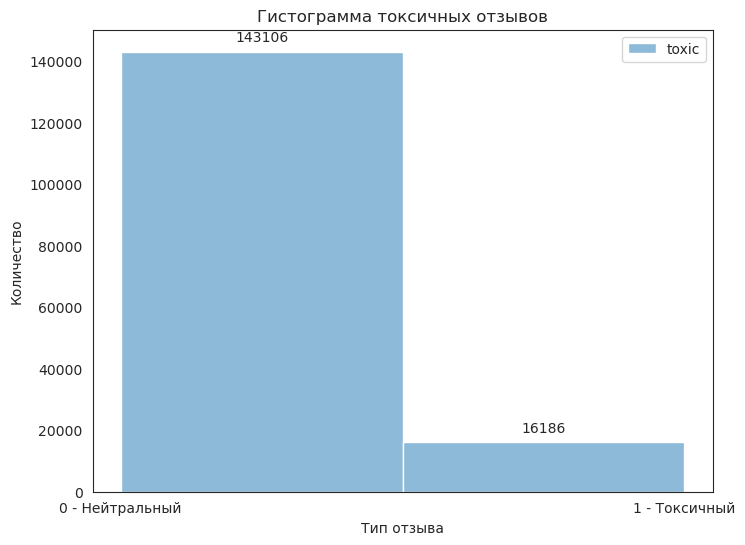

In [12]:
# Создание гистограммы с токсичными признаками
sns.set_style("white")
plt.figure(figsize=(8, 6))
ax = sns.histplot(data_df, bins=2)

# Добавление заголовка и меток осей
plt.title("Гистограмма токсичных отзывов")
plt.xlabel("Тип отзыва")
plt.ylabel("Количество")
plt.xticks([0, 1], ["0 - Нейтральный", "1 - Токсичный"])

# Добавление количества к каждому столбцу
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**ВЫВОД**

Теперь очевидно насколько сильно несбаласированные данные. Мы наблюдаем тенденциию к нейтральной окраске отзывов. С точки зрения человечесих взаимоотношений это очень хорошо, но с точки зрения машинного обучения имеет свои негативные эффекты. Значительный перевес целевого признака в пользу нейтральной окраски комментариев может привести к тому, что наша модель будет всегда оценивать коментарии как нейтральные даже в случае негативного контекста. Учтем этот инсайт во время подготовки моделей.

## BERT на GPU

Для того чтобы модель машинного обучения могла получить опыт из предоставленного корпуса, все текстовые данные необходимо векторизировать

Подготовим данные к векторизации. Проведем их токенизацию (разбиение текстов на отдельные фразы, слова, символы и т.д.). Для этих целей воспользуемся готовым токенизатором от BERT

In [13]:
%%time
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

CPU times: user 25 ms, sys: 10.7 ms, total: 35.7 ms
Wall time: 3.18 s


### Загрузка BERT модели

In [14]:
%%time
# BertConfig - конфигурация модели BERT (количество слоев, размер скрытого состояния, количество голов внимания и т.д.)
config = BertConfig.from_pretrained(model_name)

# загружает предобученную конфигурацию из онлайн-репозитория
model = BertModel.from_pretrained(model_name, config=config)
#CPU times: user 428 ms, sys: 346 ms, total: 775 ms
#Wall time: 595 ms

CPU times: user 384 ms, sys: 386 ms, total: 770 ms
Wall time: 644 ms


#### Токенизация

На этом этапе мы преобразуем текст в номера токенов из словаря загруженного ранее словаря. Добавим спец. токены. к преобразуемому тексту. Устанавим truncation=True, чтобы исключить токены, превышающие max_length.

In [15]:
%%time
input_ids, attention_mask = tokenize_and_prepare_gpu(data_df, model_name)

# Benchmark
# on T1200 
#     CPU times: user 1min 2s, sys: 25.6 s, total: 1min 28s Wall time: 51.2 s

CPU times: user 1min 4s, sys: 26.4 s, total: 1min 31s
Wall time: 52.3 s


### Инициализация эмбедингов

Эмбеддинги- представления текстовых данных в вектортной форме. Они содержат данные о соотношении разных слов и их свойствах. Привычное понимание свойства слова, его смысла в контексте окружающих его слов.

In [16]:
%%time
# Получение эмбеддингов на PyTorch
X = get_embeddings_gpu(input_ids, attention_mask,model,batch_size=25)

# No cache
# CPU times: user 3h 10min 43s, sys: 11.4 s, total: 3h 10min 54s
# Wall time: 3h 10min 51s

Загружаем эмбеддинги из кэша...
CPU times: user 41.6 ms, sys: 122 ms, total: 163 ms
Wall time: 1.92 s


In [17]:
X.shape

(159292, 768)

### Разбивка данных на обучающую, валидационную и тестовую выборки

Разобьем исходные данные в соотношении 3:1:1 (60%,20%, 20%) (размеры тестового и валидационного наборов обычно равны)

In [18]:
# Separate features (text) and target (toxic)
y = data_df['toxic']

# Разделение данных на обучающие и тестовые/валидационные (3:1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Разделение временного набора на тестовый и валидационный (1:1)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (111504, 768)
y_train shape: (111504,)
X_test shape: (23894, 768)
y_test shape: (23894,)
X_val shape: (23894, 768)
y_val shape: (23894,)


### Обучение моделей

#### LogisticRegression (Попытка 1)

In [19]:
%%time
bert_lr = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, n_jobs=10)
bert_lr.fit(X_train, y_train)

CPU times: user 40.4 s, sys: 102 ms, total: 40.5 s
Wall time: 40.5 s


LogisticRegression(n_jobs=10, random_state=42, solver='liblinear')

In [20]:
y_proba = bert_lr.predict_proba(X_val)[:, 1]
y_pred = bert_lr.predict(X_val)

In [21]:
bert_lr_roc_auc = roc_auc_score(y_val, y_proba)
print("площадь под ROC-кривой: %.3f" % bert_lr_roc_auc)

площадь под ROC-кривой: 0.962


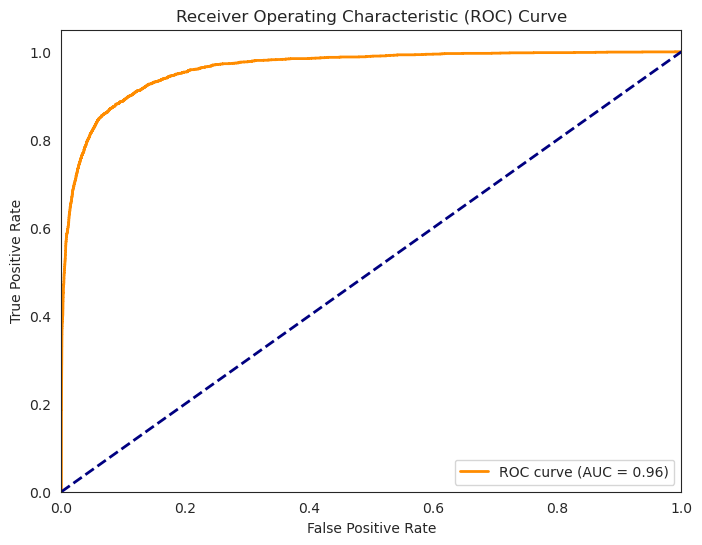

In [22]:
plot_roc_auc(y_val,y_proba)

**Промежуточный вывод**

Показатель ROC-кривой, подозрительно высокий особенно если брать в учет тот факт, что целевая метрика крайне несбалансированна и мы не делали ничего чтобы улучшить этот недостаток. Необходима проверить показатели по другим метрикам классификации(precission,recall,f1)

In [23]:
bert_lr_precision = precision_score(y_val,y_pred)
bert_lr_recall = recall_score(y_val,y_pred)
bert_lr_f1 = f1_score(y_val,y_pred)
print(f'precision={bert_lr_precision}')
print(f'recall={bert_lr_recall}')
print(f'f1={bert_lr_f1}')

precision=0.826176927056389
recall=0.6577429983525536
f1=0.7324008254987389


**Промежуточный вывод**
- Показатель точности (precission) говорит о том что из всего объема комментариев, которые модель классифицировала как токсичные  82% комментариев являются токсичными на самом деле. 

- Показатель полноты (recall) говорит о том, что модель успешно обнаруживает 65% всех токсичных коментариев
- Гармоническое среднее (f1) 0.73. среднее между полнотой и точностью



### Поправка на дисбаланс

Ранее мы уже определили, что в наших данных наблюдаетс дисбаланс данных в сторону 0(нейтральные отзывы). Теперь самое время понять каким способом будем учитывать этот нюанса. 
Итак существует 3 способа нивелировать негативные эфекты дисбаланса, рассмотрим их и проанализируем:
- Oversampling: Этот метод увеличивает количество примеров класса 1 путем дублирования существующих данных или генерации новых. В нашем случае такой подход может быть неэффективным из-за малого исходного размера этого класса. Это в свою очередь может привести к переобучению, а генерация синтетических данных нетривиальная задача. Скажем нет этому варианту
- Undersampling: В этом подходе мы уменьшеаем количество примеров класса 0. Опять же в нашем случае, это может привести к потере ценной информации и ухудшить качество обучения модели, так как пример станет значительно меньше. Отвергнем этот вариаант как неподходящий.
- Взвешивание классов: Данный подход позволяет учесть дисбаланс классов во время обучения, не изменяя размер датасета. Казалось бы для нас это самый подходящий вариант, так как создаст бОльшие веса для объектов класса 1, что позволит модели уделять больше внимания примерам класса 1, однако при таком сильном дизбалансе он так же не покажет хорошие результаты

*Выбор метода оптимизации данных*
Выбор сделаем в пользу недодескритизации, так в этом случае анализ и предсказания будут основываться на фактах а не домыслах, хотя мы понимаем что этот вариант, значительно сократит наши данные

Undersampling будем проводить в несколько этапов:
- разделим обучающую выборку на объекты по классам.
- определить класс, который содержит больше объектов.
- случайным образом отбросим часть объектов большего класса.
- создадим новую обучающую выборку.
- перемешаем данные.

In [24]:
# Инициализируем класс недодескритизации
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [25]:
print(f"X_train_undersampled shape: {X_train_undersampled.shape}")
print(f"y_train_undersampled shape: {y_train_undersampled.shape}")

X_train_undersampled shape: (22660, 768)
y_train_undersampled shape: (22660,)


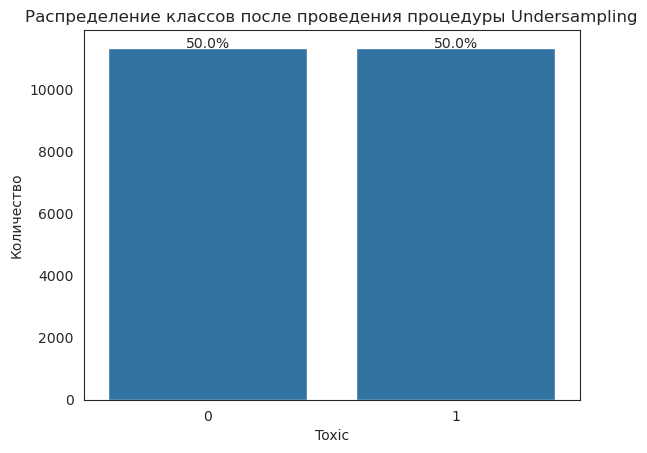

In [26]:
# Проверим как прошла балансировка классов
counts = y_train_undersampled.value_counts()
normalized_counts = y_train_undersampled.value_counts(normalize=True)

# Create the bar plot
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Toxic")
plt.ylabel("Количество")
plt.title("Распределение классов после проведения процедуры Undersampling")

# Расчитаем проценты и добавим подписи
for i, p in enumerate(normalized_counts):
    plt.text(i, counts.values[i] + 0.05, f"{p:.1%}", ha='center')
plt.show()

**Выводы**

Эффект дисбаланса нивелирован. Примерно 70% данных были отсечены

#### LogisticRegression (Попытка 2)

In [27]:
%%time
bert_lr2 = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, n_jobs=10)
bert_lr2.fit(X_train_undersampled, y_train_undersampled)

CPU times: user 7.65 s, sys: 0 ns, total: 7.65 s
Wall time: 7.66 s


LogisticRegression(n_jobs=10, random_state=42, solver='liblinear')

In [28]:
y_proba_lr2 = bert_lr2.predict_proba(X_val)[:,1]
y_pred_lr2 = bert_lr2.predict(X_val)

In [29]:
bert_lr2_roc_auc = roc_auc_score(y_val, y_proba_lr2)
print("площадь под ROC-кривой: %.3f" % bert_lr2_roc_auc)

площадь под ROC-кривой: 0.962


**Промежуточные выводы**

Обратим внимание что после проведения undersampling наша модель по прежнему показывает высокую различающую способность, отдельно отметим что данный показатель остался не изменным

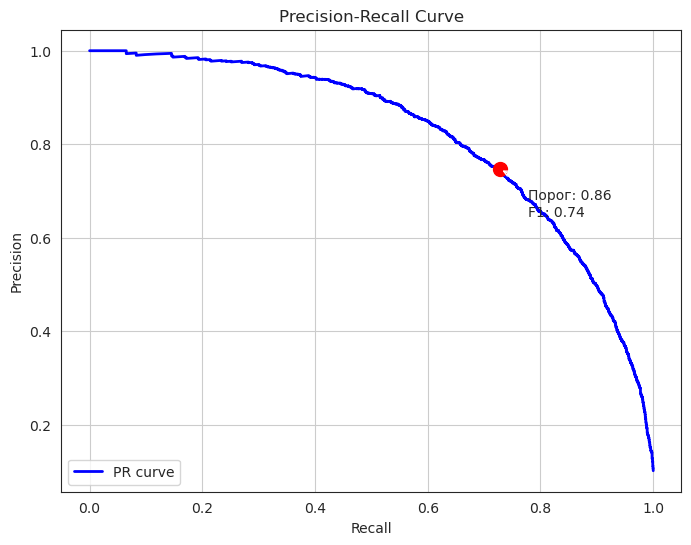

Оптимальный порог (по F1): 0.86


In [30]:
# Вычисление precision, recall, thresholds для разных порогов
precision, recall, thresholds = precision_recall_curve(y_val, y_proba_lr2)

# Построение PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# расчт оптимального порога
f1_scores = 2 * (precision * recall) / (precision + recall)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_precision = precision[best_f1_idx]
best_recall = recall[best_f1_idx]

plt.plot(best_recall, best_precision, marker='o', color='red', markersize=10)
plt.annotate(f"Порог: {best_threshold:.2f}\nF1: {f1_scores[best_f1_idx]:.2f}",
             xy=(best_recall, best_precision),
             xytext=(best_recall + 0.05, best_precision - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.legend(loc="lower left")
plt.show()

print(f"Оптимальный порог (по F1): {best_threshold:.2f}")

**Промежуточные выводы**
По показателю recal мы видим что после балансировки классов, модель стала чаще различать токсичные комментарии, что приводит к снижению точно сти так стало больше ложно-положительных сработок. Попробуем изменить это поведение увеличением порога классификации

#### SGDClassifier

SGDClassifier (Stochastic Gradient Descent Classifier) - это метод оптимизации, использующий стохастический градиентный спуск (SGD) для обучения линейных классификаторов, таких как логистическая регрессия или линейный SVM. Он не представляет собой отдельное семейство моделей.

Алгоритм SGD:

-Инициализация: Задаются гиперпараметры (размер батча, количество эпох, скорость обучения) и случайным образом инициализируются веса модели.
-Цикл по эпохам: Для каждой эпохи:
-Данные перемешиваются и делятся на батчи.
-Цикл по батчам: Для каждого батча:
-Вычисляется градиент функции потерь на данном батче.
-Веса модели обновляются в направлении, противоположном градиенту (антиградиент), с шагом, определяемым скоростью обучения.
-Результат: Алгоритм возвращает обученные веса модели.

In [31]:
%%time

pipeline = Pipeline([
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, early_stopping=True))
])

# Параметры для SGDClassifier
param_dist = {
    'sgd__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],  # Функция потерь
    'sgd__penalty': ['l1', 'l2', 'elasticnet'],  # Тип регуляризации
    'sgd__alpha': scipy.stats.loguniform(1e-4, 1e2),  # Параметр регуляризации (альфа)
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Стратегия обучения
    'sgd__eta0': scipy.stats.loguniform(1e-3, 1e0)  # Начальная скорость обучения (eta0) для некоторых стратегий
}

# Создание RandomizedSearchCV
random_search_sgd = RandomizedSearchCV(pipeline,
                                   param_distributions=param_dist,
                                   cv=5,
                                   scoring='f1',
                                   n_iter=20,
                                   n_jobs=(multiprocessing.cpu_count() - 8))

random_search_sgd.fit(X_train_undersampled, y_train_undersampled)
best_model_sgd = random_search_sgd.best_estimator_
results_sgd = random_search_sgd.cv_results_

#Benchmarks
# CPU 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz
#	Base speed:	2.50 GHz
#	Sockets:	1
#	Cores:	8
#	Logical processors:	16
# multiprocessing.cpu_count() -> 16
#
# ! Чем больше мы даем ядер, тем больше требовалось итераций чтобы достигнуть сходимости
# n_jobs=(multiprocessing.cpu_count() - 2) n_iter = 15, 'sgd__alpha': (1e-8, 1e2) - CPU avg load 50% - 100% kernel stable
#       CPU times: user 2 s, sys: 97.9 ms, total: 2.1 s Wall time: 45 s    
#       Лучшая оценка кросс-валидации: 0.8631000713129557

# n_jobs=(multiprocessing.cpu_count() - 4) n_iter=15 - CPU avg load 20% - 100% kernel stable
#       CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s Wall time: 32.1 s
#       Лучшая оценка кросс-валидации: 0.866285708607014

# n_jobs=(multiprocessing.cpu_count() - 6) - CPU avg load 20% - 100% kernel stable
#       


CPU times: user 16.9 s, sys: 938 ms, total: 17.8 s
Wall time: 35.1 s


In [32]:
# Вывод лучших найденных гиперпараметров и оценки
print("Лучшие параметры:", random_search_sgd.best_params_)
print("Лучшая оценка кросс-валидации:", random_search_sgd.best_score_)


Лучшие параметры: {'sgd__alpha': 0.006350640370773761, 'sgd__eta0': 0.018306528940090844, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'hinge', 'sgd__penalty': 'l2'}
Лучшая оценка кросс-валидации: 0.8907094014366856


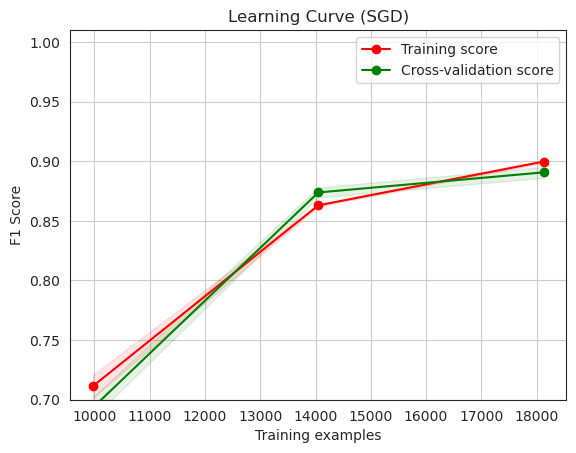

In [33]:
# Задаем заголовок графика
title = "Learning Curve (SGD)"

# Строим кривую обучения
plot_learning_curve(best_model_sgd, title, X_train_undersampled, y_train_undersampled, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()

In [34]:
%%time
# Предсказание лучшей модели
predict_sgd = best_model_sgd.predict(X_test)

# Расчет RMSE и времени выполнения предсказания
print('Показатель F1     :', f1_score(y_test, predict_sgd))


Показатель F1     : 0.6186513629842181
CPU times: user 105 ms, sys: 15.3 ms, total: 120 ms
Wall time: 23.4 ms


#### CatBoost

In [35]:
pipeline = Pipeline([
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))  # verbose=0 для отключения вывода
])

# Параметры для CatBoostClassifier
param_dist = {
    'catboost__n_estimators': scipy.stats.randint(10, 20),      # Количество деревьев
    'catboost__learning_rate': scipy.stats.uniform(0.01, 0.3),     # Скорость обучения
    'catboost__depth': scipy.stats.randint(2, 8),                 # Глубина деревьев
    'catboost__l2_leaf_reg': scipy.stats.uniform(1, 10),           # L2 регуляризация
    
}

# Создание RandomizedSearchCV
random_search_cat = RandomizedSearchCV(pipeline,
                                   param_distributions=param_dist,
                                   cv=5,
                                   scoring='f1',
                                   n_iter=5,
                                   n_jobs=(multiprocessing.cpu_count() - 10))

random_search_cat.fit(X_train_undersampled, y_train_undersampled)
best_model_cat = random_search_cat.best_estimator_
results_cat = random_search_cat.cv_results_

#Benchmarks
# CPU 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz
#	Base speed:	2.50 GHz
#	Sockets:	1
#	Cores:	8
#	Logical processors:	16
# multiprocessing.cpu_count() -> 16
#
# ! Что примечательно на параметре n_jobs=(multiprocessing.cpu_count() - 6) наблюдалась 100% загрузка CPU, ядро умерло через 3 минуты
# ! На глубине дерева выше 8 kernel died

# n_jobs=(multiprocessing.cpu_count() - 2) n_iter = 10, - CPU avg load 1000% - 100% kernel stable


In [36]:
# Вывод лучших найденных гиперпараметров и оценки
print("Лучшие параметры:", random_search_cat.best_params_)
print("Лучшая оценка кросс-валидации:", random_search_cat.best_score_)


Лучшие параметры: {'catboost__depth': 5, 'catboost__l2_leaf_reg': 8.522084984065337, 'catboost__learning_rate': 0.2629530977519697, 'catboost__n_estimators': 17}
Лучшая оценка кросс-валидации: 0.8560500392694724


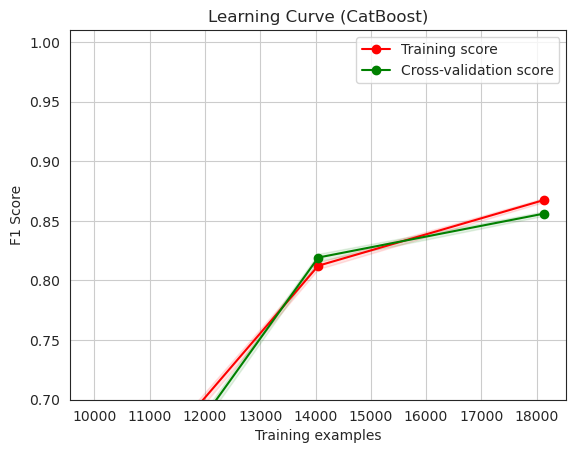

In [37]:
# Задаем заголовок графика
title = "Learning Curve (CatBoost)"

# Строим кривую обучения
plot_learning_curve(best_model_cat, title, X_train_undersampled, y_train_undersampled, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()

In [38]:
%%time
# Предсказание лучшей модели
predict_cat = best_model_cat.predict(X_test)

# Расчет RMSE и времени выполнения предсказания
print('Показатель F1     :', f1_score(y_test, predict_cat))


Показатель F1     : 0.5501470981545867
CPU times: user 1.37 s, sys: 7.67 ms, total: 1.37 s
Wall time: 120 ms


## TF-IDF

In [39]:
from scipy.stats import uniform
import spacy

Сентимент-анализ, или анализ тональности текста, позволяет определить эмоциональную окраску текста: положительную, отрицательную или нейтральную. Эта технология находит широкое применение в бизнесе, например, для оценки реакции пользователей на новый продукт или услугу.

Вместо того, чтобы тратить часы на ручной анализ тысяч отзывов, компьютер может справиться с этой задачей за считанные минуты. Сентимент-анализ решает задачу классификации, где текст помечается как "позитивный" (1) или "негативный" (0).

Для обучения модели используются признаки, основанные на словах из корпуса текстов. Одним из распространенных методов извлечения признаков является TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF учитывает как частоту встречаемости слова в конкретном тексте (TF), так и его "уникальность" в рамках всего корпуса (IDF). Таким образом, слова, которые часто встречаются в конкретном тексте, но редко встречаются в других текстах, получают больший вес, что помогает модели лучше различать эмоциональную окраску.

Помимо бинарной классификации (позитив/негатив), сентимент-анализ может применяться для более тонкой оценки эмоций, например, для определения уровня гнева, радости, грусти и других эмоций, выраженных в тексте.

Сентимент-анализ - мощный инструмент, позволяющий компаниям быстро и эффективно получать ценную информацию из текстовых данных.

In [40]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")
stopwords_en = list(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zai11972/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zai11972/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zai11972/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zai11972/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
%%time
# avg time ~ 14 min
# 1. Лемматизация
data_df['text'] = data_df['text'].apply(lemmatize_text_spacy)

# 2. Сплитование
X_train, X_test, y_train, y_test = train_test_split(
    data_df['text'], data_df['toxic'], test_size=0.2, random_state=42, stratify=data_df['toxic']
)
# CPU times: user 10min 26s, sys: 262 ms, total: 10min 26s
# Wall time: 10min 36s

CPU times: user 10min 26s, sys: 262 ms, total: 10min 26s
Wall time: 10min 36s


In [42]:
%%time
# 3. Векторизация
vectorizer = TfidfVectorizer(stop_words=stopwords_en)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

CPU times: user 4.22 s, sys: 29.7 ms, total: 4.25 s
Wall time: 4.29 s


### LogisticRegression

In [43]:
%%time
pipeline = Pipeline(
    [
        ('logreg', LogisticRegression(solver='saga', random_state=RANDOM_STATE))
    ]
)

param_dist = {
    'logreg__C': uniform(loc=5, scale=10),
    'logreg__penalty': ['l1']  
}

# Создание объекта RandomizedSearchCV
random_search_logreg = RandomizedSearchCV(pipeline, 
                                          param_distributions=param_dist, 
                                          cv=3, 
                                          scoring='f1', 
                                          n_iter=3, 
                                          n_jobs=2
                                         )

random_search_logreg.fit(X_train_vect, y_train)

/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

CPU times: user 4min 59s, sys: 675 ms, total: 4min 59s
Wall time: 19min 24s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('logreg',
                                              LogisticRegression(random_state=42,
                                                                 solver='saga'))]),
                   n_iter=3, n_jobs=2,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcffc2c6c20>,
                                        'logreg__penalty': ['l1', 'l2']},
                   scoring='f1')

In [44]:
best_model_logreg = random_search_logreg.best_estimator_
results_logreg = random_search_logreg.cv_results_

In [45]:
# Вывод лучших найденных гиперпараметров и оценки
print("Лучшие параметры:", random_search_logreg.best_params_)
print("Лучшая оценка кросс-валидации:", random_search_logreg.best_score_)

Лучшие параметры: {'logreg__C': 11.070670701703467, 'logreg__penalty': 'l1'}
Лучшая оценка кросс-валидации: 0.7670453311088431


### SGDClassifier

In [46]:
%%time
param_dist = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': uniform(loc=1e-4, scale=1e-3),  
    'l1_ratio': uniform(loc=0, scale=1),     
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': uniform(loc=1e-3, scale=1e-2)    
}

# Создание объекта RandomizedSearchCV
random_search_sgd = RandomizedSearchCV(
    SGDClassifier(random_state=RANDOM_STATE),  # Передача SGDClassifier напрямую
    param_distributions=param_dist,
    cv=5,
    scoring='f1',
    n_iter=3,
    n_jobs=2
)


# Обучение модели
random_search_sgd.fit(X_train_vect, y_train)

CPU times: user 4.4 s, sys: 151 ms, total: 4.55 s
Wall time: 30.5 s


RandomizedSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_iter=3,
                   n_jobs=2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd0c414d810>,
                                        'eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd0c4e02500>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd0c414d8a0>,
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['hinge', 'log',
                                                 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='f1')

In [47]:
# Вывод лучших найденных гиперпараметров и оценки
print("Лучшие параметры:", random_search_sgd.best_params_)
print("Лучшая оценка кросс-валидации:", random_search_sgd.best_score_)

Лучшие параметры: {'alpha': 0.0004421119805227942, 'eta0': 0.008986363764161016, 'l1_ratio': 0.43432148070427024, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'penalty': 'l1'}
Лучшая оценка кросс-валидации: 0.6300423043144411


###  CatBoobsClassifier

In [48]:
%%time
# Pipeline не нужен так как CatBoostClassifier сам по себе является полноценной моделью.
# Параметры для RandomizedSearchCV
param_dist = {
    'learning_rate': uniform(loc=0.01, scale=0.1),  # Равномерное распределение от 0.01 до 0.11
    'depth': [4]
}

# Создание объекта RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(
    CatBoostClassifier(eval_metric='F1', random_state=RANDOM_STATE),  # Передача CatBoostClassifier напрямую
    param_distributions=param_dist,
    cv=2,
    scoring='f1',
    n_iter=1,
    n_jobs=1
)

# Обучение модели
random_search_catboost.fit(X_train_vect, y_train)

0:	learn: 0.3609079	total: 335ms	remaining: 5m 34s
1:	learn: 0.4018634	total: 465ms	remaining: 3m 52s
2:	learn: 0.3718077	total: 596ms	remaining: 3m 18s
3:	learn: 0.3779135	total: 736ms	remaining: 3m 3s
4:	learn: 0.3722792	total: 880ms	remaining: 2m 55s
5:	learn: 0.3843478	total: 1.02s	remaining: 2m 49s
6:	learn: 0.4220850	total: 1.16s	remaining: 2m 44s
7:	learn: 0.4213333	total: 1.29s	remaining: 2m 39s
8:	learn: 0.4267762	total: 1.42s	remaining: 2m 36s
9:	learn: 0.4275362	total: 1.55s	remaining: 2m 33s
10:	learn: 0.4641261	total: 1.68s	remaining: 2m 31s
11:	learn: 0.4336741	total: 1.81s	remaining: 2m 29s
12:	learn: 0.4710289	total: 1.94s	remaining: 2m 27s
13:	learn: 0.4703678	total: 2.07s	remaining: 2m 25s
14:	learn: 0.4737519	total: 2.2s	remaining: 2m 24s
15:	learn: 0.4758903	total: 2.32s	remaining: 2m 22s
16:	learn: 0.4769015	total: 2.46s	remaining: 2m 22s
17:	learn: 0.4772568	total: 2.59s	remaining: 2m 21s
18:	learn: 0.4827106	total: 2.73s	remaining: 2m 20s
19:	learn: 0.4808654	tot

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fd352a593c0>,
                   n_iter=1, n_jobs=1,
                   param_distributions={'depth': [4],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd0c414d870>},
                   scoring='f1')

In [49]:
best_model_catboobs = random_search_catboost.best_estimator_

In [50]:
# Вывод лучших найденных гиперпараметров и оценки
print("Лучшие параметры:", random_search_catboost.best_params_)
print("Лучшая оценка кросс-валидации:", random_search_catboost.best_score_)

Лучшие параметры: {'depth': 4, 'learning_rate': 0.06945974364082809}
Лучшая оценка кросс-валидации: 0.725227476021304


###  Лучшая модель

In [51]:
# Прогнозирование на X_test
y_pred_lr = best_model_logreg.predict(X_test_vect)

f1 = f1_score(y_test, y_pred_lr)

print("F1-мера модели с LogisticRegression:", f1)

if f1 > 0.75:
    print("F1-мера модели выше 0.75. Качество модели удовлетворяет условиям проекта.")
else:
    print("F1-мера модели ниже 0.75. Необходимо улучшить модель.")


F1-мера модели с LogisticRegression: 0.7796271637816246
F1-мера модели выше 0.75. Качество модели удовлетворяет условиям проекта.


In [54]:
# Сравнение с базовой моделью
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(X_train_vect, y_train)
y_pred_dummy = dummy_clf.predict(X_test_vect)
f1_dummy = f1_score(y_test, y_pred_dummy)

print("F1-мера базовой модели:", f1_dummy)
#Сравнение с базовой моделью
if f1 > f1_dummy:
    print("Модель LogReg превосходит базовую модель.")
else:
    print("Модель LogReg не превосходит базовую модель. Необходимо провести дополнительный анализ.")

F1-мера базовой модели: 0.1844654661499886
Модель LogReg превосходит базовую модель.
